# Chest_Disease_Detection_Using_CNN

#### Development of a model that automates the process of detecting and classifying chest disease with the purpose of reducing the cost and time of detection. This project is organised as follows: (a) Data Visualization and data proccessing, (b) Build and train CNN model, (c) Evaluate trained CNN model.

Introduction:
* AI/ML/DL has been revolutionizing healthcare and medicine in areas such as: (a) Medical imagery, (b) Drug research, (c) Genome development
* Deel learning has been proven to be superior in detecting and classifying disease using imagery data.
* Skin cancer could be detected more accurately by deep learning (95%) than by dermatologists(86.6%) (2018).

Reference: https://www.theguardian.com/society/2018/may/29/skin-cancer-computer-learns-to-detect-skin-cancer-more-accurately-than-a-doctor


#### In this case study, the operations team of a hospital has collected extensive X-Ray chest data which will be used for the development of a model that could detect and classify the diseases in less than 5 minutes. The provided data consists of 133 images that belong to 4 class: (a) Healthy, (b) Covid-19, (c) Bacterial Pneumonia, (d) Viral Pneumonia. The data set is initially divided into training and test categories for validati

## 0. Import reqired libraries

#### (a) Import required libraries

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1. Read dataset

#### (a) Specify training data directory

In [2]:
XRay_Directory =r"C:\Users\Tam\Desktop\Data Science Projects\Chest_Disease_Detection_Using_CNN\Dataset"

**Comment:** Adjust the path of the directory based on where the dataset is saved on the user's computer.

In [3]:
os.listdir(XRay_Directory)

['0', '1', '2', '3']

#### (b) Use of image generator to generate tensor images data and normalize them using 20% of the data for cross-validation.

In [4]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

#### (c) Generate batches of 40 images and perform shuffling and image resizing.

(i) Training data

In [5]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


(ii) Validation data

In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


#### (d) Generate a batch of 40 images and labels

In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 4)

#### (e) Create labels Translator

In [10]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

**Comment:** The 0 label represents a patient with Covid-19, the 1 label represents a health patient, the 2 label represents a patient with Viral Pneumonia and the 3 label represent a patient with Bacterial Pneumonia.

## 2. Visualize Dataset

#### (a) Display a grid of 36(6x6) Images from the dataset along with their corresponding labels.

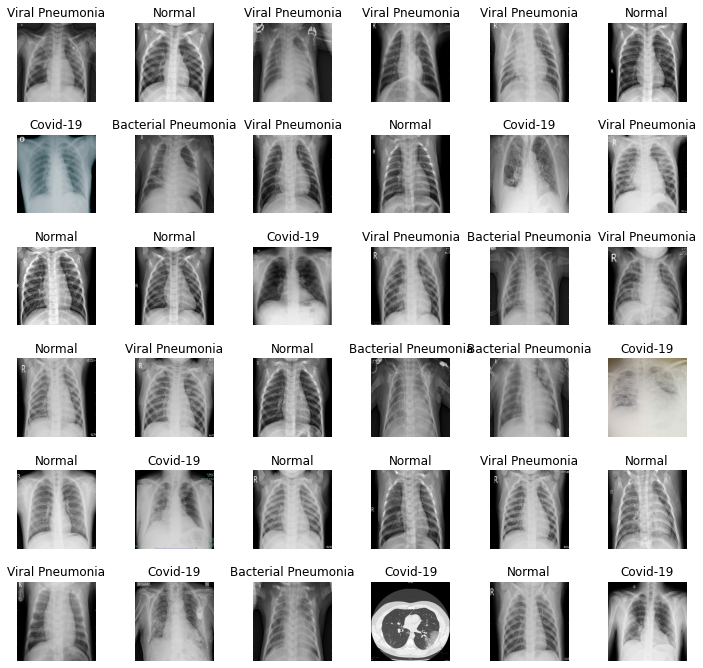

In [11]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)   

## 3. Import a pretrained ResNet50 model tha has been trained with Imagenet dataset

#### (a) Import the trained ResNet50 model

In [12]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

**Comment:** The model has been trained using the imagenet dataset.

#### (b) Imported model summary

In [13]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### (c) Freeze the model's layers but leave only the last 10 layers of the model to be trainable

In [14]:
for layer in basemodel.layers[:-10]:
  layers.trainable = False

**Comment:** The last 10 layers of the model are then able to be trained with the new X-ray deep learning model.

## 4. Build and train the deep learning model

**Comment:** The model will be built on top of the previous pretrained model. 

#### (a) Model building

In [15]:
#Use pretrained model
headmodel = basemodel.output
#Add average pooling layer
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
#Add flattening layer
headmodel = Flatten(name= 'flatten')(headmodel)
# Add dense layer with 256 neurons and apply relu activation function
headmodel = Dense(256, activation = "relu")(headmodel)
#Drop 30% of the neurons to avoid Codependency
headmodel = Dropout(0.3)(headmodel)
# Add dense layer with 256 neurons and apply relu activation function
headmodel = Dense(256, activation = "relu")(headmodel)
#Drop 30% of the neurons to avoid Codependency
headmodel = Dropout(0.3)(headmodel)
# Add dense layer with 256 neurons and apply relu activation function
headmodel = Dense(256, activation = "relu")(headmodel)
#Drop 30% of the neurons to avoid Codependency
headmodel = Dropout(0.3)(headmodel)
#Add final dense layer with 4 outputs and apply softmax activation function
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

#### (b) Model configuration for training

(i) Compile model

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

(ii) Use early stopping to exit training if validation loss is not decreasing after a certain number of epochs

In [17]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

(iii) Save the best model with the lowest validation loss

In [18]:
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

**Commment:** The best model is everytime saved as "weights.hdf5"

#### (c) Generate images 

In [19]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [20]:
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


#### (d) Fit the model into the training data (25 epochs)

In [21]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

Epoch 1/25
107/107 [==============================] - 211s 2s/step - loss: 1.2960 - accuracy: 0.4838 - val_loss: 4.2105 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 4.21046, saving model to weights.hdf5
Epoch 2/25
107/107 [==============================] - 213s 2s/step - loss: 0.5278 - accuracy: 0.8308 - val_loss: 10.0431 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 4.21046
Epoch 3/25
107/107 [==============================] - 218s 2s/step - loss: 0.2145 - accuracy: 0.9214 - val_loss: 25.9584 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 4.21046
Epoch 4/25
107/107 [==============================] - 225s 2s/step - loss: 0.3814 - accuracy: 0.8953 - val_loss: 11.0250 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 4.21046
Epoch 5/25
107/107 [==============================] - 234s 2s/step - loss: 0.1197 - accuracy: 0.9648 - val_loss: 7.7703 - val_accuracy: 0.2500

Epoch 00005: val_loss did not improve from 

## 5. Evaluate trained deep learning model

#### (a) Plot history of model training


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

(i) Accuracy and loss

Text(0, 0.5, 'Training accuracy and loss')

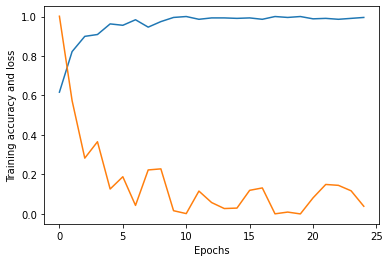

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')

**Comment:** In this figure it is plotted the history for loss(orange) and accuracy(blue) for the 25 epochs.

(ii) Validation loss

Text(0, 0.5, 'Validation loss')

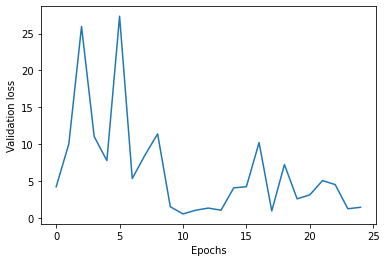

In [24]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

**Comment:** In this figure it is plotted the validation loss over the 25 epochs.

(iii) Validation accuracy

Text(0, 0.5, 'Validation accuracy')

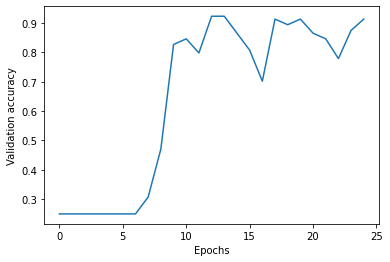

In [25]:
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')

**Comment:** In this figure it is plotted the validation accuracy over the 25 epochs.

#### (b) Import and proccess testing data

In [26]:
test_directory =r"C:\Users\Tam\Desktop\Data Science Projects\Chest_Disease_Detection_Using_CNN\Test"

**Comment:** We are using the initially seperated testing data to validate our trained model.

#### (c) Evaluate models accuracy

In [27]:
test_gen=ImageDataGenerator(rescale=1./255)
test_generator=test_gen.flow_from_directory(batch_size=40,directory=test_directory,shuffle=True,target_size=(256,256),class_mode='categorical')

Found 40 images belonging to 4 classes.


In [28]:
evaluate=model.evaluate(test_generator,steps=test_generator.n //4, verbose=1)

10/10 [==============================] - 3s 4ms/step - loss: 5.0360 - accuracy: 0.7250


In [29]:
print('Accuracy Test: {}'.format(evaluate[1]))

Accuracy Test: 0.7250000238418579


#### (d) Model's scikit-learn metrics

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

(i) Accuracy

In [31]:
score=accuracy_score(original,prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.75


(ii) Classification Report

In [32]:
print(classification_report(np.asarray(original),np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.71      1.00      0.83        10
           2       1.00      0.40      0.57        10
           3       0.86      0.60      0.71        10

    accuracy                           0.75        40
   macro avg       0.81      0.75      0.73        40
weighted avg       0.81      0.75      0.73        40



(iii) Confusion Matrix

Text(0.5, 1.0, 'Confusion_matrix')

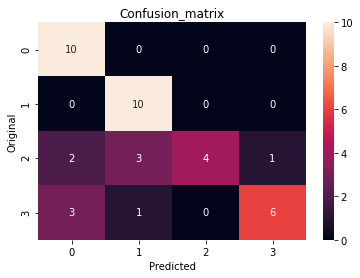

In [33]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

#### (e) A sample of the model's predictions

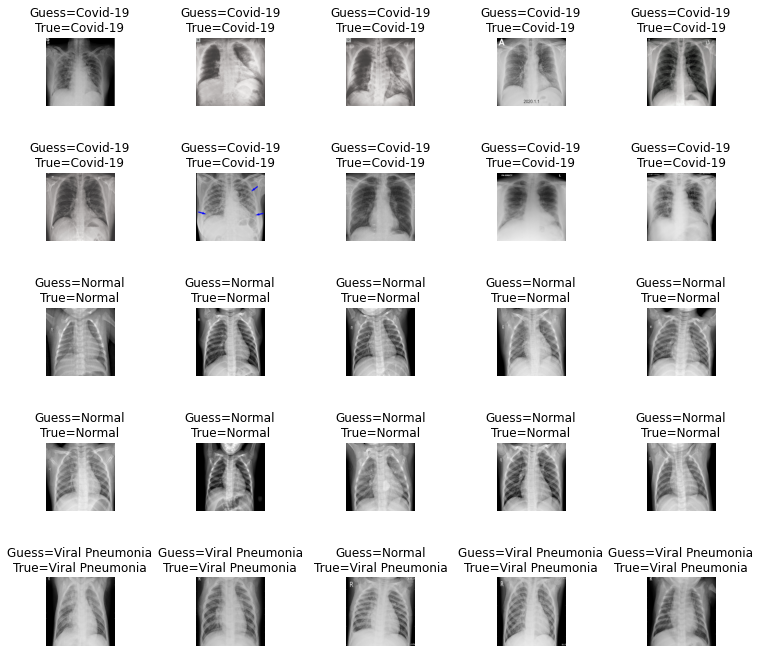

In [34]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 